In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import ggplot, aes, geom_bar, geom_line, facet_wrap, theme_minimal, labs

In [104]:
df = pd.read_csv('../src/metrics_results.csv')

In [119]:
df['Precision_Diff'].describe()

count    848.000000
mean       0.027724
std        0.093298
min       -0.253197
25%       -0.033333
50%        0.025211
75%        0.081008
max        0.458791
Name: Precision_Diff, dtype: float64

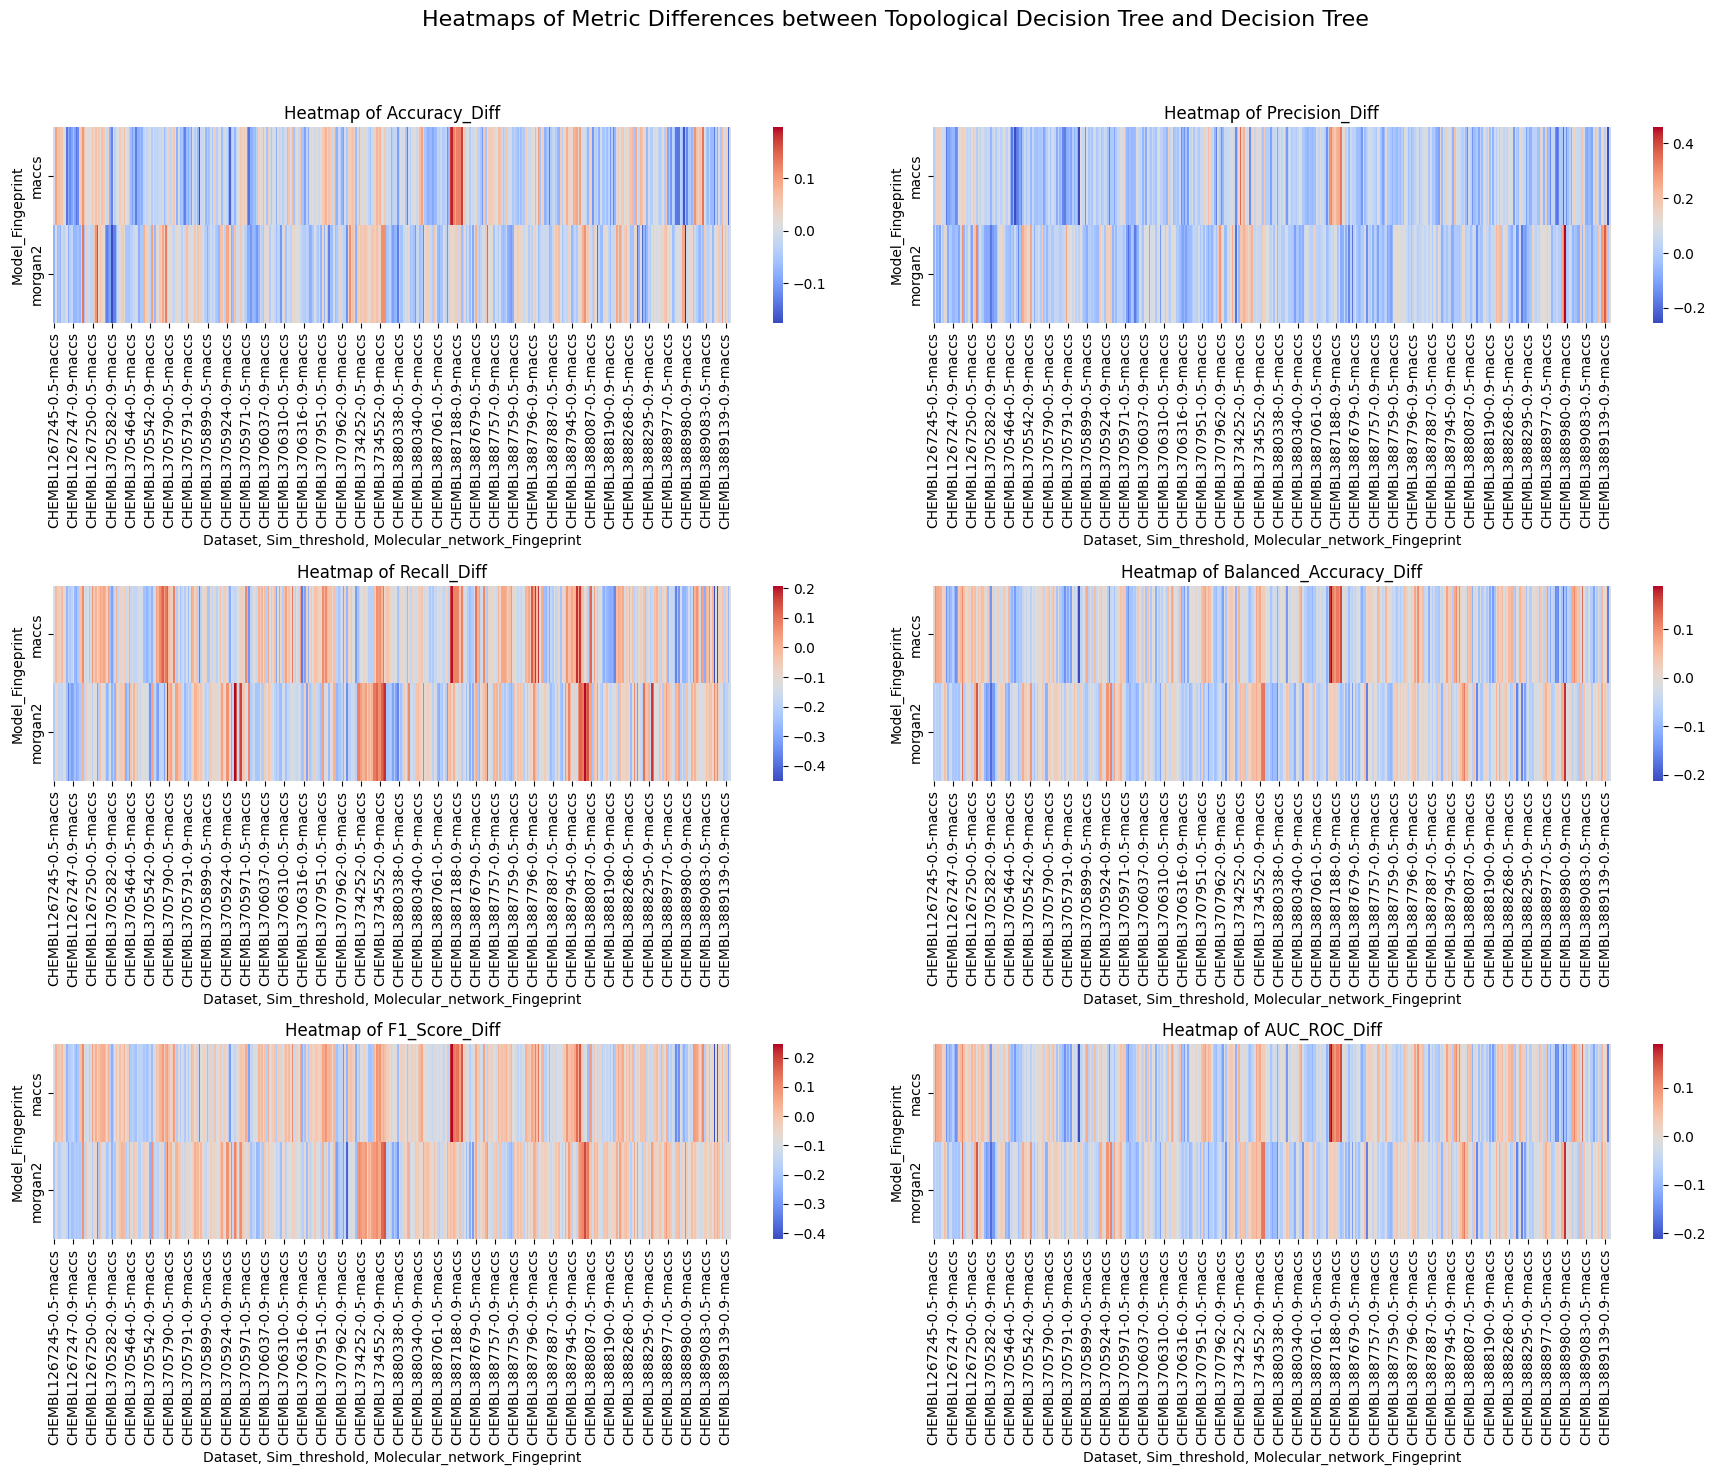

In [117]:
# Calculate differences in metrics
df['Accuracy_Diff'] = df['Topological_Decision_Tree_Accuracy'] - df['Decision_Tree_Accuracy']
df['Precision_Diff'] = df['Topological_Decision_Tree_Precision'] - df['Decision_Tree_Precision']
df['Recall_Diff'] = df['Topological_Decision_Tree_Recall'] - df['Decision_Tree_Recall']
df['Balanced_Accuracy_Diff'] = df['Topological_Decision_Tree_Balanced_Accuracy'] - df['Decision_Tree_Balanced_Accuracy']
df['F1_Score_Diff'] = df['Topological_Decision_Tree_F1_Score'] - df['Decision_Tree_F1_Score']
df['AUC_ROC_Diff'] = df['Topological_Decision_Tree_AUC_ROC'] - df['Decision_Tree_AUC_ROC']

# List of metric differences to plot
metrics = ['Accuracy_Diff', 'Precision_Diff', 'Recall_Diff', 'Balanced_Accuracy_Diff', 'F1_Score_Diff', 'AUC_ROC_Diff']

# Create a single figure with multiple subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 15))
fig.suptitle('Heatmaps of Metric Differences between Topological Decision Tree and Decision Tree', fontsize=16)

# Group the data by the relevant columns and calculate mean differences
grouped = df.groupby(['Dataset', 'Sim_threshold', 'Molecular_network_Fingeprint', 'Model_Fingeprint']).mean().reset_index()

# Iterate over metrics and axes
for i, metric in enumerate(metrics):
    # Determine row and column index
    row = i // 2
    col = i % 2
    
    # Create a pivot table for the heatmap
    pivot_table = grouped.pivot_table(index='Model_Fingeprint', columns=['Dataset', 'Sim_threshold', 'Molecular_network_Fingeprint'], values=metric)
    
    # Plot the heatmap on the corresponding subplot
    sns.heatmap(pivot_table, annot=False, cmap='coolwarm', ax=axes[row, col])
    axes[row, col].set_title(f'Heatmap of {metric}')
    axes[row, col].set_xlabel('Dataset, Sim_threshold, Molecular_network_Fingeprint')
    axes[row, col].set_ylabel('Model_Fingeprint')

# Adjust layout for better viewing
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

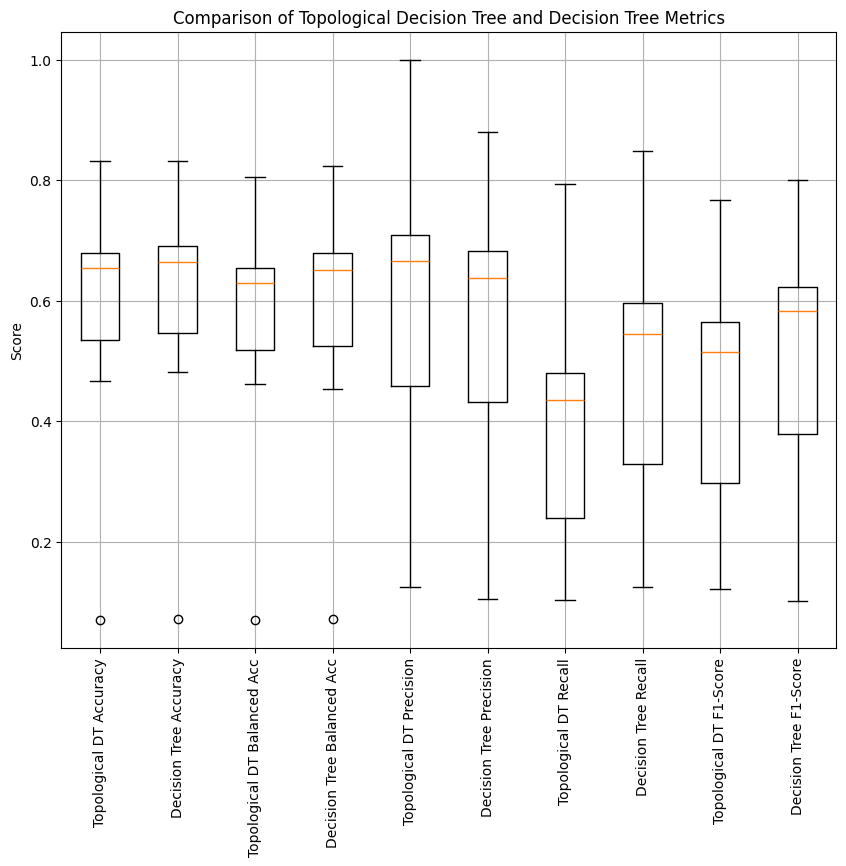

In [61]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Plot boxplots for the metrics
ax.boxplot([
    data["Topological_Decision_Tree_Accuracy"],
    data["Decision_Tree_Accuracy"],
    data["Topological_Decision_Tree_Balanced_Accuracy"],
    data["Decision_Tree_Balanced_Accuracy"],
    data["Topological_Decision_Tree_Precision"],
    data["Decision_Tree_Precision"],
    data["Topological_Decision_Tree_Recall"],
    data["Decision_Tree_Recall"],
    data["Topological_Decision_Tree_F1_Score"],
    data["Decision_Tree_F1_Score"]
], labels=[
    "Topological DT Accuracy", "Decision Tree Accuracy",
    "Topological DT Balanced Acc", "Decision Tree Balanced Acc",
    "Topological DT Precision", "Decision Tree Precision",
    "Topological DT Recall", "Decision Tree Recall",
    "Topological DT F1-Score", "Decision Tree F1-Score"
])

# Customize plot
ax.set_title("Comparison of Topological Decision Tree and Decision Tree Metrics")
ax.set_ylabel("Score")
ax.grid(True)
plt.xticks(rotation=90)  # Rotate x-axis labels for readability

# Show the plot
plt.show()

# Visualising Topological impurity reduction in practice

In [153]:
import os
from joblib import load
os.chdir('../benchmark')

In [185]:
clf = load("./clf.joblib")

In [186]:
clf

{'split_feature': 277,
 'split_value': 0,
 'left': {'split_feature': 1295,
  'split_value': 0,
  'left': {'split_feature': 327,
   'split_value': 0,
   'left': {'split_feature': 295,
    'split_value': 0,
    'left': {'split_feature': 79,
     'split_value': 0,
     'left': {'split_feature': 314,
      'split_value': 0,
      'left': {'split_feature': 148,
       'split_value': 0,
       'left': {'leaf': True,
        'class': 0,
        'topological_impurity': 0.25,
        'P_active': '1/2'},
       'right': {'leaf': True,
        'class': 1,
        'topological_impurity': 0.0,
        'P_active': '2/2'},
       'topological_impurity': 0.1875,
       'P_active': '3/4'},
      'right': {'split_feature': 752,
       'split_value': 0,
       'left': {'split_feature': 33,
        'split_value': 0,
        'left': {'split_feature': 241,
         'split_value': 0,
         'left': {'split_feature': 204,
          'split_value': 0,
          'left': {'leaf': True,
           'class': 0,
  

In [188]:
import pydot

def plot_binary_decision_tree(tree_dict):
    def add_node_and_edges(graph, node, node_id):
        # Create the current node in the graph
        if 'leaf' in node:
            # Leaf node
            label = f"class: {node['class']}\nimpurity: {node['topological_impurity']:.2f}\nP_active: {node['P_active']}"
            graph.add_node(pydot.Node(node_id, label=label, shape='ellipse', style='filled', fillcolor='lightblue'))
        else:
            # Decision node
            label = f"split_feature: {node['split_feature']}\nsplit_value: {node['split_value']}\nP_active: {node['P_active']}\nimpurity: {node['topological_impurity']:.2f}"
            graph.add_node(pydot.Node(node_id, label=label, shape='box'))

            # Recur on left and right children
            left_node_id = f"{node_id}_left"
            right_node_id = f"{node_id}_right"
            
            # Add left and right child nodes
            add_node_and_edges(graph, node['left'], left_node_id)
            add_node_and_edges(graph, node['right'], right_node_id)
            
            # Add edges from current node to left and right children
            graph.add_edge(pydot.Edge(node_id, left_node_id, label='left'))
            graph.add_edge(pydot.Edge(node_id, right_node_id, label='right'))
    
    # Create a graph
    graph = pydot.Dot(graph_type='digraph')

    # Start adding nodes and edges from the root
    add_node_and_edges(graph, tree_dict, "root")
    
    # Display the graph
    graph.write_png('binary_decision_tree.png')
    print("Decision tree plotted and saved as 'binary_decision_tree.png'.")

# Plot the binary decision tree
plot_binary_decision_tree(clf)

Decision tree plotted and saved as 'binary_decision_tree.png'.


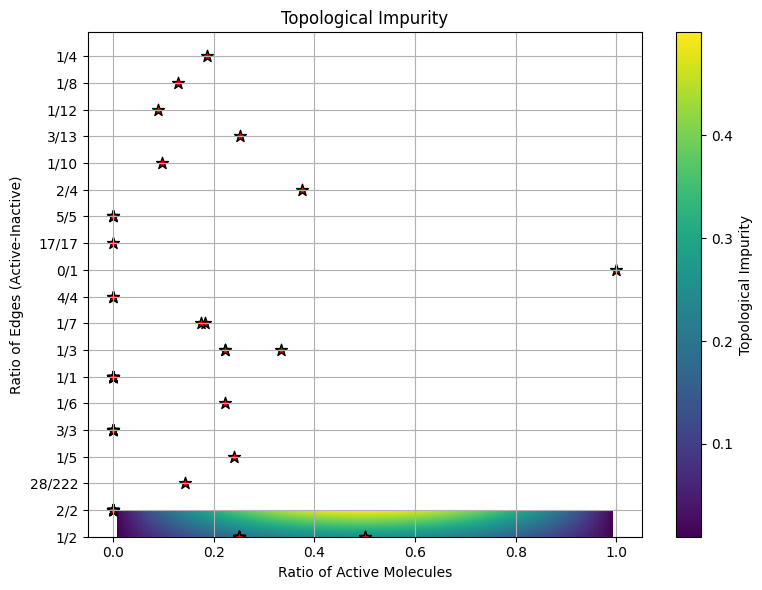

In [181]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize

# Define a function to calculate TGI_binary
def TGI_binary(ratio_active, ratio_inactive, edge_ratio):
    """
    Calculates Topological Impurity (TGI) for binary classification.

    Args:
    ratio_active: Ratio of active molecules (0 to 1).
    ratio_inactive: Ratio of inactive molecules (0 to 1).
    edge_ratio: Ratio of edges between active and inactive molecules (0 to 1).

    Returns:
    TGI value.
    """
    return ratio_active * ratio_inactive * (1 + edge_ratio)

# Generate dense data for smooth visualization
num_points = 200
ratio_active = np.linspace(0.01, 0.99, num_points)
ratio_inactive = 1 - ratio_active
edge_ratios = np.linspace(0, 1, num_points)

# Calculate TGI for all combinations
TGI_values = np.zeros((num_points, num_points))
for i, edge_ratio in enumerate(edge_ratios):
    for j, _ in enumerate(ratio_active):
        TGI_values[i, j] = TGI_binary(ratio_active[j], ratio_inactive[j], edge_ratio)

# Create the plot
plt.figure(figsize=(8, 6))

# Use pcolormesh for efficient color mapping of 2D data
extent = (ratio_active.min(), ratio_active.max(), edge_ratios.min(), edge_ratios.max())
plt.pcolormesh(ratio_active, edge_ratios, TGI_values, cmap='viridis', norm=Normalize(vmin=TGI_values.min(), vmax=TGI_values.max()))

# Customize the plot
plt.xlabel('Ratio of Active Molecules')
plt.ylabel('Ratio of Edges (Active-Inactive)')
plt.title('Topological Impurity')
plt.grid(True)
plt.colorbar(label='Topological Impurity')


# Function to traverse the tree and collect P_active and topological_impurity
def extract_leaf_data(tree, p_active_list=[], top_impurity_list=[]):
    if 'leaf' in tree:
        # Collect P_active and topological_impurity from the leaf node
        p_active_list.append(tree['P_active'])
        top_impurity_list.append(tree['topological_impurity'])
    else:
        # Recur on the left and right children
        extract_leaf_data(tree['left'], p_active_list, top_impurity_list)
        extract_leaf_data(tree['right'], p_active_list, top_impurity_list)


# Extract P_active and topological_impurity from the binary decision tree
p_active_list = []
top_impurity_list = []
extract_leaf_data(clf, p_active_list, top_impurity_list)

# Plot scatter points on the background
plt.scatter(top_impurity_list, p_active_list, color='red', marker='*', s=80, edgecolor='black', linewidth=1)

# Show the plot
plt.tight_layout()
plt.show()
